<a href="https://colab.research.google.com/github/Baah134/Baah134/blob/main/Generative_Adversarial_Network_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow matplotlib tensorflow datasets ipywidgets
#installing dependencies

In [ ]:
import tensorflow as tf
#importing fashion dataset
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt


In [ ]:
#Loading datasets into variable using tensorflow api
#'fashion_mnist' specifies which dataset is being loaded
ds = tfds.load('fashion_mnist', split='train')

In [ ]:
#Checking nature of data
ds

In [ ]:
#Visualizing data
import numpy as np
#Building iterator to constantly fetch data
dataiterator= ds.as_numpy_iterator()
dataiterator.next()

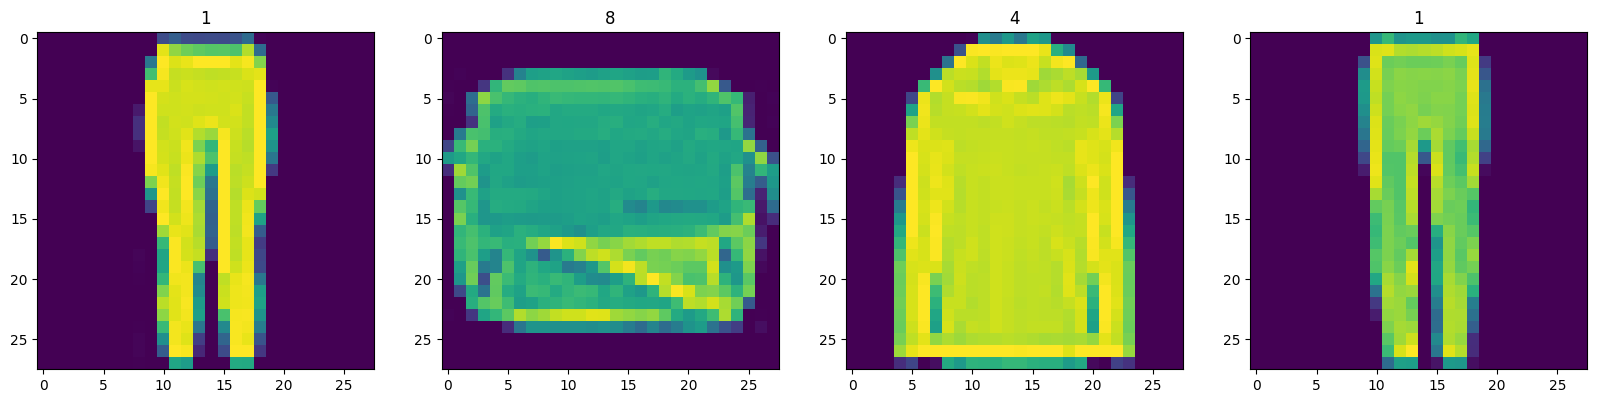

In [ ]:
#Setting up matplotlib
fig, ax = plt.subplots(ncols =4, figsize=(20,20))
#Looping to pick four shapes
for idx in range(4):
  #Grab image and label
  sample = dataiterator.next()
  #Plot image
  ax[idx].imshow(np.squeeze(sample['image']))
  #Print image and prints the axis
  ax[idx].title.set_text(sample['label'])

In [ ]:
#Normalizing data
def normalize_data(data):
  image = data['image']
  return image/255

In [ ]:
#Reloading dataset
ds = tfds.load('fashion_mnist', split='train')

ds = ds.map(normalize_data)
ds = ds.cache()
#Shuffle data
ds = ds.shuffle(60000)
#Batch into 128 images per sample
ds = ds.batch(128)
#Reduces possibility of bottlenecking
ds = ds.prefetch(64)

In [ ]:
ds.as_numpy_iterator().next().shape

(128, 28, 28, 1)

In [ ]:
from tensorflow.keras.layers import Dense, Conv2D, Flatten, LeakyReLU, Reshape, UpSampling2D, Dropout
from tensorflow.keras.models import Sequential

In [ ]:
def build_generator():
  model = Sequential()

  #Takes in random values and reshapes to 7x7x128
  #Beginning of a generated image


  model.add(Dense(7*7*128, input_dim = 128))
  model.add(LeakyReLU(0.2))
  model.add(Reshape((7,7,128)))

  #Block 1
  model.add(UpSampling2D()) #increases dimension of image
  model.add(Conv2D(128,5,padding='same'))
  model.add(LeakyReLU(0.2))

  #Block 2
  model.add(UpSampling2D()) #increases dimension of image
  model.add(Conv2D(128,5,padding='same'))
  model.add(LeakyReLU(0.2))

  #Down sampling
  model.add(Conv2D(128,4,padding='same'))
  model.add(LeakyReLU(0.2))

  model.add(Conv2D(128,4,padding='same'))
  model.add(LeakyReLU(0.2))

  #Final channel
  model.add(Conv2D(1,4,padding="same", activation= 'sigmoid'))





  return model

In [ ]:
test_model = build_generator()
test_model.summary()

In [ ]:
generator = build_generator()

In [ ]:
img = generator.predict(np.random.randn(4,128,1))

1/1 [==============================] - 0s 173ms/step


In [ ]:
img.shape

(4, 28, 28, 1)

1/1 [==============================] - 0s 48ms/step


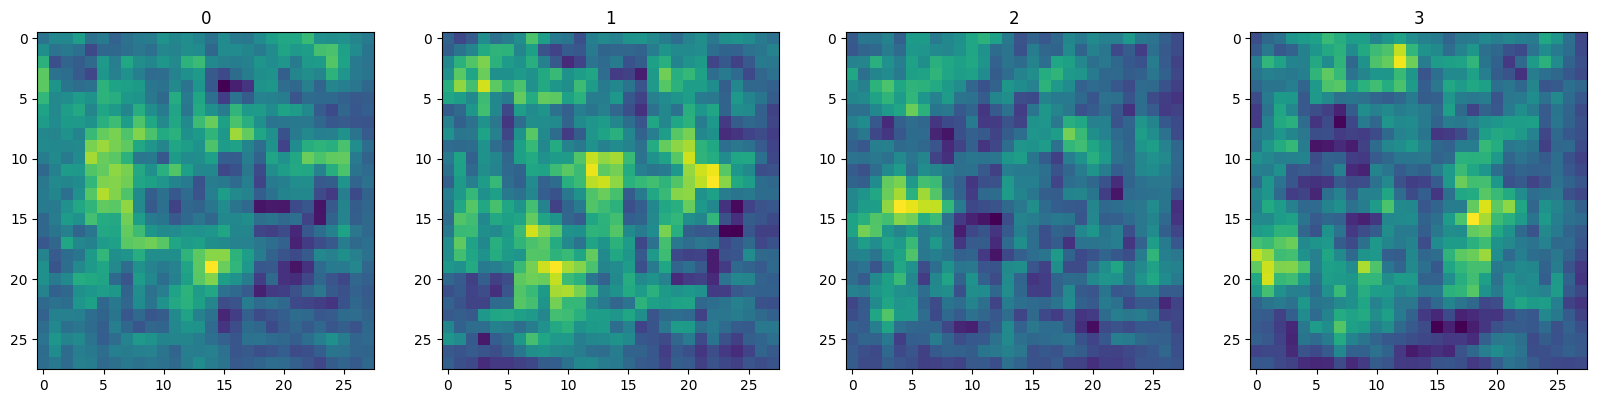

In [ ]:
img = generator.predict(np.random.randn(4,128,1))
#Setting up matplotlib
fig, ax = plt.subplots(ncols =4, figsize=(20,20))
#Looping to pick four shapes
for idx,img in enumerate(img):
  #Plot image
  ax[idx].imshow(np.squeeze(img))
  #Print image and prints the axis
  ax[idx].title.set_text(idx)

In [ ]:
def build_discriminator():
  model = Sequential()

  model.add(Conv2D(32,5,input_shape=(28,28,1)))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  model.add(Conv2D(64,5))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  model.add(Conv2D(128,5))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  model.add(Conv2D(256,5))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  model.add(Flatten())
  model.add(Dropout(0.4))
  model.add(Dense(1, activation='sigmoid'))

  return model

In [ ]:
discriminator = build_discriminator()
discriminator.summary()

In [ ]:
img.shape

(28, 28, 1)

In [ ]:
discriminator.predict(np.expand_dims(img,0)) #used when predicting image on a deep neural network

1/1 [==============================] - 0s 79ms/step


array([[0.50190806]], dtype=float32)

In [ ]:
#Importing loss and optimizer fuunctions
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

In [ ]:
#Creating instances of loss and optimizer functions
g_opt = Adam(learning_rate=0.0001)
d_opt = Adam(learning_rate=0.00001)
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

In [ ]:
#Importing model
from tensorflow.keras.models import Model

In [ ]:
class FashionGAN(Model):
  def _init_(self, generator, discriminator, *args, **kwargs):
    super()._init_(*args, **kwargs)
    #Crating attributes
    self.generator = generator
    self.discriminator = discriminator
    pass
  def compile(self, g_opt, g_loss, d_opt, d_loss,*args, **kwargs):

    super().compile(*args, **kwargs)
    self.g_opt = g_opt
    self.g_loss = g_loss
    self.d_opt = d_opt
    self.d_loss = d_loss
    pass
  def train_step(self, batch):
    #Get data
    real_images = batch
    fake_images = self.generator(tf.random.normal((128,128,1)), training= False)

    #Train discriminator
    with tf.GradientTape as d_tape:
      #Pass the real and fake images to the model
      yhat_real = self.discriminator(real_images, training= True)
      yhat_fake = self.discriminator(fake_images, training = True)
      yhat_realfake = tf.concat([yhat_real, yhat_fake], axis = 0)


     #Create labels
     y_realfake = tf.concat([tf.zeros_like(yhat_real),tf.ones_like(yhat_fake), axis = 0])

      #Add some noise
      noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
      noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
      y_realfake += tf.concat([noise_real, noise_fake], axis =0)

      #Calculate loss
      total_d_loss = self.d_loss(y_realfake, yhat_realfake)

    #Apply backpropagation
    dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables)
    self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))

    #Train the generator
    with tf.GradientTape() as g_tape:
      #Generate new images
      gen_images = self.generator(tf.random.normal((128,128,1)), training= True)
      #Create the predicted labels
      predicted_labels =self.discriminator(gen_images, training= False)
      #Calculate loss
      total_g_loss =self.g_loss(tf.zeros_like(predicted_labels),predicted_labels)
    #Apply backpropagation
    ggrad = g_tape.gradient(total_g_loss,self.generator.trainable_variables)
    self.g_opt.apply_gradient(zip(ggrad,self.generator.trainable_variables))

    return{'d_loss: total_d_loss', 'g_loss':total_g_loss}


In [ ]:
#Create instance of subclass model
fashgan = FashionGAN(generator,discriminator)

In [ ]:
fashgan.compile(g_opt, d_opt, g_loss, d_loss)

In [ ]:
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tesorflow.keras.callbacks import Callback

In [ ]:
hist = fashgan.fit(ds, epochs = 20)